In [1]:
reset -fs

In [2]:
import numpy as np
import pandas as pd
import os
import glob
import dl_functions
from IPython.display import display
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.preprocessing.image import array_to_img, img_to_array
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from skimage import io, color, exposure, transform
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.cross_validation import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline

Using TensorFlow backend.


#### Images we will resized as specified below.

In [3]:
IMG_SIZE = 250

#### Directory where images from epicurious.com will be downloaded.

In [4]:
ok_images='data/downloads/ok'

#### Directory where images from food.com will be downloaded.

In [5]:
nok_images='data/downloads/nok'

#### Creating an array of images already pre-processed and ready to fit a model. Array is normalized.
Note that we stack first the 'good' images, then the 'bad' ones.

In [6]:
X = np.vstack((dl_functions.create_images_array(ok_images, IMG_SIZE), dl_functions.create_images_array(nok_images, IMG_SIZE)))/255.

/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


#### Creating an array of labels.
Label 1 indicates good image, and 0 bad image. Note that half of the images are good, half are bad, so labels are calculated accordingly.

In [7]:
y = np.vstack((np.array([1]*(len(X)/2)).reshape((len(X)/2), 1), np.array([0]*(len(X)/2)).reshape((len(X)/2), 1)))

#### Creating a train, test split.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### The labels need to be converted to categorical. Note that we have 2 categories: good (1) and bad (0) images.

In [9]:
y_train_sparse = np_utils.to_categorical(y_train, 2)

In [10]:
y_test_sparse = np_utils.to_categorical(y_test, 2)

#### Creating and instance of a CNN model.

In [11]:
model = dl_functions.cnn_model_baseline(IMG_SIZE)

In [12]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 3, 250, 32)        72032     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 248, 32)        9248      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 248, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 248, 64)        18496     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 248, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 248, 128)       73856     
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 248, 128)       0         
__________

In [14]:
model.fit(X_train, y_train_sparse, batch_size=128, epochs=20, verbose=1, validation_split=0.3)

Train on 588 samples, validate on 252 samples
Epoch 1/20
588/588 [==============================] - 31s - loss: 5.4252 - acc: 0.4847 - val_loss: 7.0996 - val_acc: 0.5595
Epoch 2/20
588/588 [==============================] - 31s - loss: 8.3332 - acc: 0.4830 - val_loss: 7.0996 - val_acc: 0.5595
Epoch 3/20
588/588 [==============================] - 31s - loss: 8.3332 - acc: 0.4830 - val_loss: 7.0996 - val_acc: 0.5595
Epoch 4/20
588/588 [==============================] - 31s - loss: 8.3332 - acc: 0.4830 - val_loss: 7.0996 - val_acc: 0.5595
Epoch 5/20
588/588 [==============================] - 30s - loss: 8.3332 - acc: 0.4830 - val_loss: 7.0996 - val_acc: 0.5595
Epoch 6/20
588/588 [==============================] - 31s - loss: 8.3332 - acc: 0.4830 - val_loss: 7.0996 - val_acc: 0.5595
Epoch 7/20
588/588 [==============================] - 31s - loss: 8.3332 - acc: 0.4830 - val_loss: 7.0996 - val_acc: 0.5595
Epoch 8/20
588/588 [==============================] - 31s - loss: 8.3332 - acc: 0.4830

In [15]:
score = model.evaluate(X_test, y_test_sparse, verbose=1)

360/360 [==============================] - 5s     


In [16]:
print('Test loss: {:0,.4f}'.format(score[0]))
print('Test accuracy: {:.2%}'.format(score[1]))

Test loss: 8.2829
Test accuracy: 48.61%


#### Creating a list of predictions.

In [17]:
predicted_images = []
for i in model.predict(X_test):
  predicted_images.append(np.where(np.max(i) == i)[0])

#### Displaying a confusion matrix.

dl_functions.py:186: RuntimeWarning: invalid value encountered in divide
  'Pos Pred Val: %.2f'%(tp/(tp+fp+0.)),


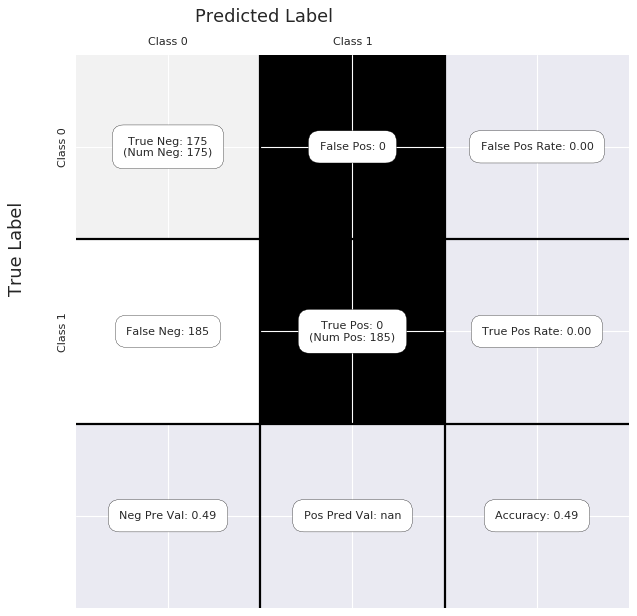

In [18]:
dl_functions.show_confusion_matrix(confusion_matrix(y_test, predicted_images), ['Class 0', 'Class 1'])

In [19]:
pd.DataFrame(confusion_matrix(y_test,predicted_images),columns = ['nok_image','ok_image'])

,nok_image,ok_image
0,175,0
1,185,0


In [20]:
predictions_probability = model.predict_proba(X_test)

360/360 [==============================] - 5s     


#### Plotting a ROC curve.

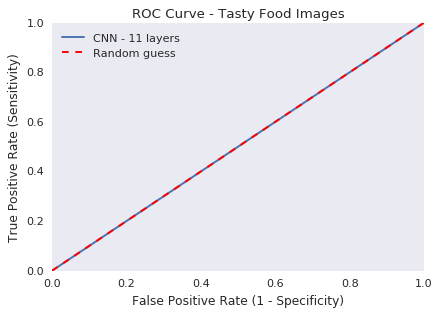

In [21]:
dl_functions.plot_roc(y_test, predictions_probability[:,1], "CNN - " + str(len(model.layers)) + " layers", "Tasty Food Images")

### Prediction using an image of Donald Trump.
<img src='images/trump_1.jpg' />

In [22]:
trump = np.array(dl_functions.preprocess_img(io.imread('images/trump_1.jpg'), IMG_SIZE), dtype='float32')

In [23]:
trump_exp = np.expand_dims(trump, axis=0)

In [24]:
trump_prediction = model.predict_classes(trump_exp)

1/1 [==============================] - 0s


In [25]:
trump_prediction[0]

0

#### The model predicts the image as bad.

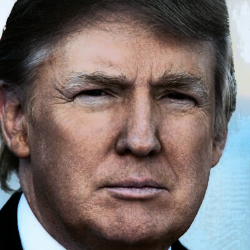

In [26]:
img = array_to_img(trump, data_format='channels_first')
display(img)